<a href="https://colab.research.google.com/github/stevengregori92/Learn-XGBoost-with-Polynomial/blob/main/PremiumInsurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install luwiji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.9 MB/s eta 0:00:00
  Created wheel for luwiji: filename=luwiji-1.2.1-py2.py3-none-any.whl size=40366830 sha256=74109fc0583496c57e477dfab15620aa1335be8fd2d913f0e16bb2509bb5bc1f
  Stored in directory: /root/.cache/pip/wheels/ba/90/9e/943ac5067e9cdc185d8f029a1d13278acd52839118acc06c9a
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32178 sha256=6eef9bcafa8149839610067c359bd41b479c2ad182694037fa914a72a2e1df97
  Stored in directory: /root/.cache/pip/wheels/5e/06/58/749e5f1baf2932285758798a92793d4347888826160b025808
Successfully built luwiji jcopml


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [3]:
!gdown https://drive.google.com/uc?id=19xUr5vE7QBniNVoo5B3ZYHDRcyprmZsG

Downloading...
From: https://drive.google.com/uc?id=19xUr5vE7QBniNVoo5B3ZYHDRcyprmZsG
To: /content/premium.zip
100% 7.25k/7.25k [00:00<00:00, 29.3MB/s]


In [4]:
!unzip /content/premium.zip

Archive:  /content/premium.zip
  inflating: Medicalpremium.csv      


In [30]:
df = pd.read_csv('Medicalpremium.csv')
pd.options.display.max_columns=50
df

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,15000
982,64,1,1,0,0,153,70,0,0,3,28000
983,56,0,1,0,0,155,71,0,0,1,29000
984,47,1,1,0,0,158,73,1,0,1,39000


,missing_value,%
Age,0,0.0
Diabetes,0,0.0
BloodPressureProblems,0,0.0
AnyTransplants,0,0.0
AnyChronicDiseases,0,0.0
Height,0,0.0
Weight,0,0.0
KnownAllergies,0,0.0
HistoryOfCancerInFamily,0,0.0
NumberOfMajorSurgeries,0,0.0


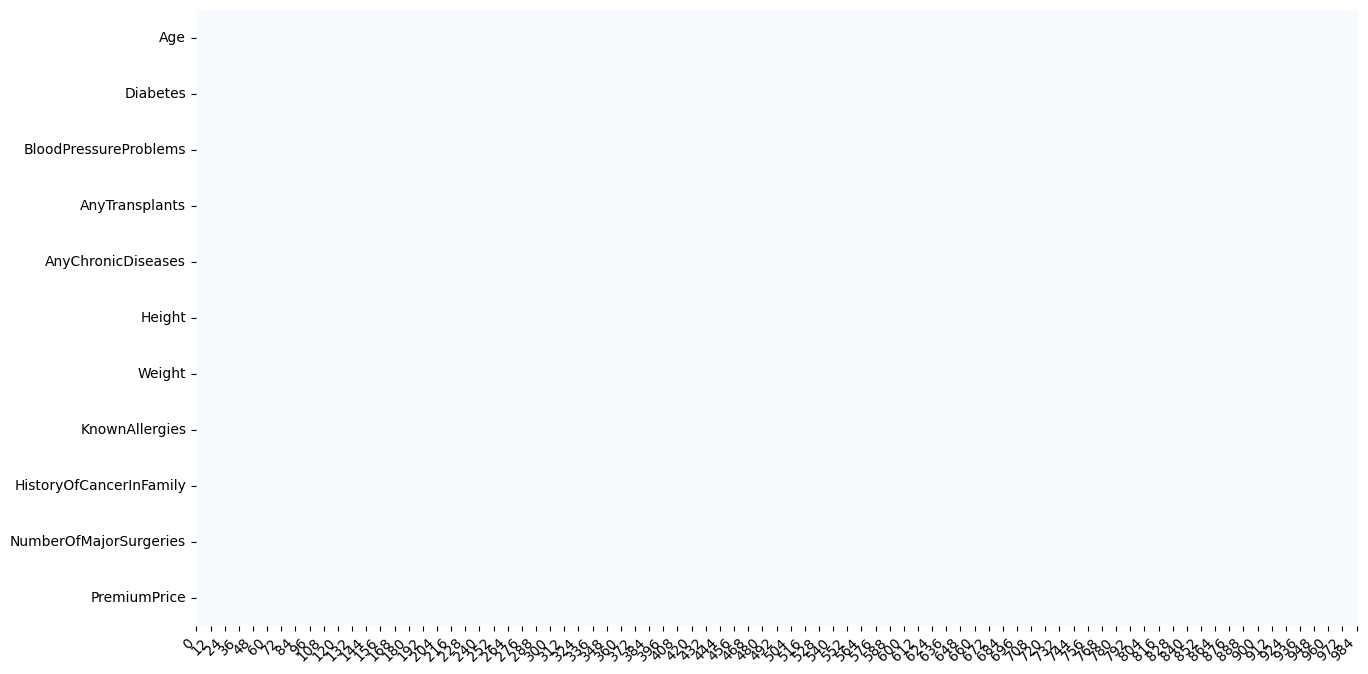

In [31]:
plot_missing_value(df, return_df=True)

#Dataset Splitting

In [32]:
X = df.drop(columns=['PremiumPrice'])
y = df.PremiumPrice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((788, 10), (198, 10), (788,), (198,))

#PCA

In [36]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [37]:
pca = PCA().fit(X_train)

Text(0, 0.5, 'Cumulative Explained Variance')

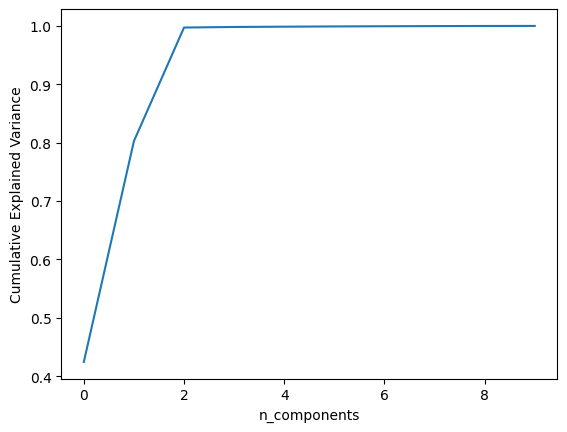

In [38]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('n_components')
plt.ylabel('Cumulative Explained Variance')

#Training

In [10]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [11]:
df.columns

Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies',
       'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice'],
      dtype='object')

In [20]:
df.NumberOfMajorSurgeries.value_counts()

0    479
1    372
2    119
3     16
Name: NumberOfMajorSurgeries, dtype: int64

In [41]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['Age', 'Height', 'Weight']),
    ('categoric', cat_pipe(), ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases',
                               'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    # ('pca', PCA(n_components=3, whiten=True)),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter = 50, n_jobs=-1, verbose=1, random_state = 42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.9763799669573133, 'algo__gamma': 3, 'algo__learning_rate': 0.05820013372709852, 'algo__max_depth': 4, 'algo__n_estimators': 163, 'algo__reg_alpha': 0.07362945281639222, 'algo__reg_lambda': 2.752717392942944, 'algo__subsample': 0.6401537692938899}
0.8979284663412559 0.7324962705794671 0.8689159704784155


#Feature Importance

,feature,importance,stdev
0,Age,1.321945,0.050422
3,AnyTransplants,0.225790,0.011834
6,Weight,0.170955,0.010419
4,AnyChronicDiseases,0.059231,0.009139
5,Height,0.041225,0.008270
9,NumberOfMajorSurgeries,0.037718,0.005253
8,HistoryOfCancerInFamily,0.030624,0.002215
2,BloodPressureProblems,0.021145,0.003144
7,KnownAllergies,0.005355,0.000857
1,Diabetes,0.004318,0.001200


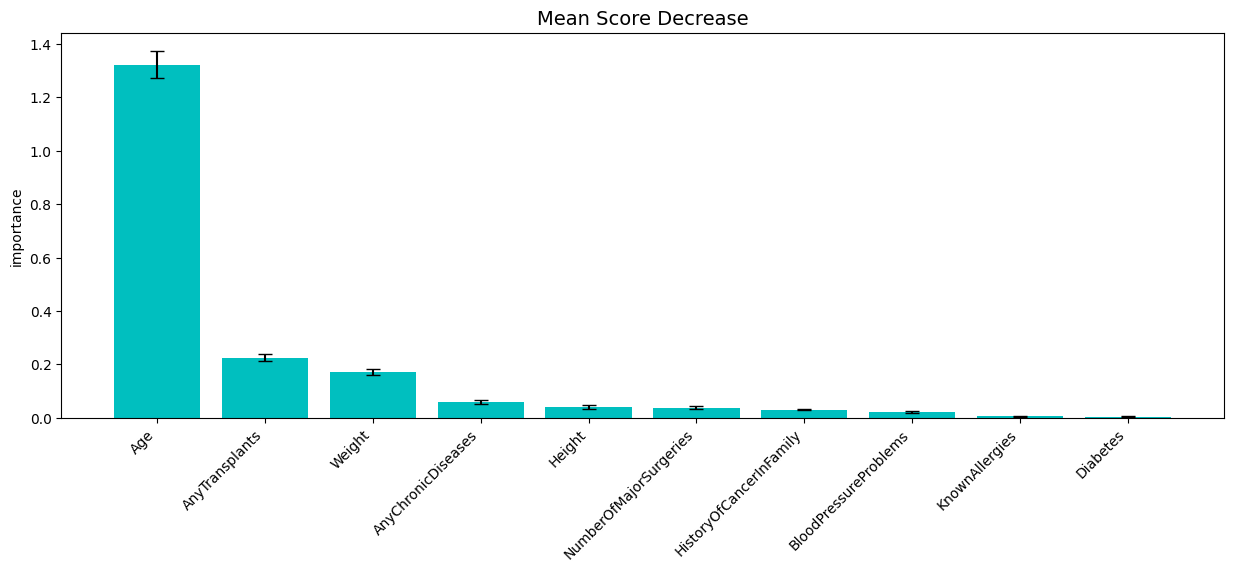

In [23]:
mean_score_decrease(X_train, y_train, model, plot=True)

In [24]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['Age', 'Weight']),
    ('categoric', cat_pipe(), ['AnyTransplants'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter = 50, n_jobs=-1, verbose=1, random_state = 42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.5261245937025092, 'algo__gamma': 1, 'algo__learning_rate': 0.08498604636076731, 'algo__max_depth': 5, 'algo__n_estimators': 122, 'algo__reg_alpha': 0.0015568103018717575, 'algo__reg_lambda': 6.2601238645330595, 'algo__subsample': 0.7433401936490238}
0.7993533891078324 0.6633156087799489 0.8064130433620214


#Polynomial

In [25]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['Age', 'Height', 'Weight']),
    ('categoric', cat_pipe(), ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases',
                               'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=3, n_iter = 50, n_jobs=-1, verbose=1, random_state = 42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.7273141668957412, 'algo__gamma': 6, 'algo__learning_rate': 0.05235791002299295, 'algo__max_depth': 10, 'algo__n_estimators': 125, 'algo__reg_alpha': 1.739616742284701, 'algo__reg_lambda': 2.9396070097391545, 'algo__subsample': 0.7566202762782357, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': True}
0.9761065726909192 0.7520213832387795 0.8684402729579497
